<a href="https://www.kaggle.com/code/allenlu112220/pokemon-type-classification?scriptVersionId=244274791" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Pokémon Type Classification (Classification of the Primary Type of Pokémon)

## Introduction

Pokémon usually have animal characteristics and distinctive colors corresponding to their types. For example, Fire-type Pokémon are often red, Grass-type are usually green, Dark-type are often black, etc. Therefore, color is an important feature representing their type, although there are exceptions.  
Similarly, animal features such as turtles, fish, wings, etc., also represent their types. However, exceptions exist—for example, some Pokémon with turtle characteristics have the Fire type.

## This Practice Involves

- Classifying Pokémon based on their primary type  
- Using a CNN model to train on the Pokémon training and validation sets and making predictions on the test set  


**Import Libraries:**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras import layers, models, utils, preprocessing
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dropout, Flatten,
    Dense, Activation, BatchNormalization, Lambda
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image


**Read CSV File**

In [4]:
csv_data = pd.read_csv("../input/pokemon-images-and-types/pokemon.csv")
csv_data.info

<bound method DataFrame.info of             Name     Type1   Type2   Evolution
0      bulbasaur     Grass  Poison     ivysaur
1        ivysaur     Grass  Poison    venusaur
2       venusaur     Grass  Poison         NaN
3     charmander      Fire     NaN  charmeleon
4     charmeleon      Fire     NaN   charizard
..           ...       ...     ...         ...
804    stakataka      Rock   Steel         NaN
805  blacephalon      Fire   Ghost         NaN
806      zeraora  Electric     NaN         NaN
807       meltan     Steel     NaN         NaN
808     melmetal     Steel     NaN         NaN

[809 rows x 4 columns]>

**Load data**

In [6]:
images_data = "../input/pokemon-images-and-types/images/"

**Map CSV Data to Images**

In [7]:
pokemon_filenames = os.listdir(images_data)

pnames, primary_types, secondary_types = [], [], []
for path in pokemon_filenames:
    # Extract Pokémon name
    pokemon_name = path.split('.')[0]
    # Extract Pokémon primary and secondary types
    row = csv_data[csv_data['Name'] == pokemon_name]
    idx = int(row.index.values[0])
    type1 = csv_data['Type1'][idx]
    type2 = csv_data['Type2'][idx]
    # Append to new lists
    pnames.append(pokemon_name.capitalize())
    primary_types.append(type1)  
    secondary_types.append(type2)

# Create new data
pokemon_d = {'Image': pokemon_filenames, 'Pokemon': pnames, 'Primary_Type': primary_types, 'Secondary_Type': secondary_types}
pokemon_data = pd.DataFrame(pokemon_d)

# View data
print(pokemon_data)
print(pokemon_data['Primary_Type'].value_counts())


            Image   Pokemon Primary_Type Secondary_Type
0       throh.png     Throh     Fighting            NaN
1    samurott.png  Samurott        Water            NaN
2    venomoth.png  Venomoth          Bug         Poison
3      latios.png    Latios       Dragon        Psychic
4       shinx.png     Shinx     Electric            NaN
..            ...       ...          ...            ...
804  shieldon.png  Shieldon         Rock          Steel
805  gigalith.png  Gigalith         Rock            NaN
806  magearna.png  Magearna        Steel          Fairy
807    ledyba.png    Ledyba          Bug         Flying
808     riolu.png     Riolu     Fighting            NaN

[809 rows x 4 columns]
Primary_Type
Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Fighting     29
Dark         29
Ghost        27
Dragon       27
Steel        26
Ice          23
Fairy        18
Flying        3
Nam

**Map Test Set Images to CSV Data**

In [8]:
numbers = []
for i in range(1, csv_data.shape[0] + 1):
    numbers.append(i)
csv_data['pkn'] = numbers  # Insert identification column

IMG_DIR = '/kaggle/input/pokemon-images-dataset/pokemon/pokemon'
from os import listdir
from os.path import isfile, join

onlyfiles = [f for f in listdir(IMG_DIR) if isfile(join(IMG_DIR, f))]  # Get all files in the directory (filenames)

import re
dataframe_img = pd.DataFrame([])
images = []
pokemon_number = []

for img in onlyfiles:
    if not re.search('-', img):  # Ignore files with '-' in filename
        pkn = img.split('.')  # Split filename and extension, e.g. ['1', 'png']
        n = re.sub("[^0-9]", "", pkn[0])  # Remove non-numeric characters
        path = str(img)
        images.append(path)
        pokemon_number.append(n)

dataframe_img['Image'] = images
dataframe_img['pkn'] = pokemon_number
dataframe_img['pkn'] = dataframe_img['pkn'].astype(int)  # Convert string to int

pokemon_test = csv_data.merge(dataframe_img, left_on='pkn', right_on='pkn')  # Merge dataframes on 'pkn'
pokemon_test.rename(columns={'Name': 'Pokemon', 'Type1': 'Primary_Type', 'Type2': 'Secondary_Type'}, inplace=True)

pokemon_test['Primary_Type'].value_counts()

Primary_Type
Water       103
Normal       91
Grass        64
Bug          61
Fire         47
Psychic      46
Rock         41
Electric     35
Ground       29
Poison       28
Dark         28
Fighting     25
Dragon       24
Ice          23
Steel        22
Ghost        22
Fairy        17
Flying        2
Name: count, dtype: int64

**Split Data**

In [9]:
# Delete output folders if they exist
import shutil
import os

if os.path.exists('train/'):
    shutil.rmtree('train/') 
if os.path.exists('test/'):
    shutil.rmtree('test/') 
if os.path.exists('val/'):
    shutil.rmtree('val/') 

# Create folders for training, testing, and validation sets
from shutil import copyfile, copy2

if not os.path.exists('train/'):
    os.mkdir('train/')
if not os.path.exists('test/'):
    os.mkdir('test/')
if not os.path.exists('val/'):
    os.mkdir('val/')

# Create subfolders based on Pokémon primary types inside train/test/val folders
for class_ in pokemon_data['Primary_Type'].unique():
    if not os.path.exists(f'train/{class_}/'):
        os.mkdir(f'train/{class_}/')
    if not os.path.exists(f'test/{class_}/'):
        os.mkdir(f'test/{class_}/')
    if not os.path.exists(f'val/{class_}/'):
        os.mkdir(f'val/{class_}/')


In [10]:
# Split training and validation sets, 67% train, 33% validation
X_train, X_val, y_train, y_val = train_test_split(
    pokemon_data, 
    pokemon_data['Primary_Type'], 
    test_size=0.33, 
    stratify=pokemon_data['Primary_Type'], 
    random_state=0
)

# Test set
X_test, y_test = pokemon_test, pokemon_test['Primary_Type']

In [11]:
# Copy images from training set to train folder categorized by primary type
for image, type_ in zip(X_train['Image'], y_train):
    src = os.path.join(images_data, image)
    dst = os.path.join('train', type_)
    copy2(src, dst)

# Copy images from test set to test folder categorized by primary type
for image, type_ in zip(X_test['Image'], y_test):
    src = os.path.join(IMG_DIR, image)
    dst = os.path.join('test', type_)
    copy2(src, dst)

# Copy images from validation set to val folder categorized by primary type
for image, type_ in zip(X_val['Image'], y_val):
    src = os.path.join(images_data, image)
    dst = os.path.join('val', type_)
    copy2(src, dst)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(542, 4)
(708, 6)
(267, 4)


In [12]:
datagen = ImageDataGenerator()

train = datagen.flow_from_directory('train/')
test = datagen.flow_from_directory('test/')
val = datagen.flow_from_directory('val/')

Found 542 images belonging to 18 classes.
Found 708 images belonging to 18 classes.
Found 267 images belonging to 18 classes.


## Build Classification Model

- Use CNN architecture
- 3 convolutional layers
- MaxPooling2D layers after convolutions
- Dropout for regularization     

In [18]:
# Modeling

## Define Model
def build():
    model = Sequential()  # Sequential model
    IMAGE_WIDTH = 256
    IMAGE_HEIGHT = 256
    IMAGE_CHANNELS = 3  # 3 channels (RGB)
    
    # Add a lambda layer as input
    model.add(Lambda(lambda x: x, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
    
    # Parameters below are selected based on multiple experiments with best results
    
    # First convolutional layer with 32 filters of size 3x3, activation function: relu
    model.add(Conv2D(32, (3, 3), activation='relu'))
    
    # Batch normalization to normalize the output and reduce internal covariate shift
    model.add(BatchNormalization())
    
    # Max pooling with pool size 3x3 and stride of 3, reduces computation and captures spatial invariance
    model.add(MaxPooling2D(pool_size=(3, 3)))
    
    # Dropout to randomly deactivate 30% neurons to prevent overfitting
    model.add(Dropout(0.3))
    
    # Second convolution: convert 32 feature maps to 64
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))
    
    # Third convolution: convert 64 feature maps to 128
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))
    
    # Flatten the multi-dimensional input tensors
    model.add(Flatten())
    
    # Fully connected dense layer with 512 neurons
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    
    # Dropout with 50% to prevent overfitting
    model.add(Dropout(0.5))
    
    # Output layer with 18 neurons for 18 primary types
    # Softmax converts outputs to class probabilities
    model.add(Dense(18, activation='softmax')) 
    
    # Print model summary
    model.summary()
    
    # Compile model
    # loss: categorical crossentropy for multi-class classification
    # optimizer: adam for fast convergence
    # metrics: track accuracy during training
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    
    return model
model = build()
history = model.fit(train, epochs=25, validation_data=val)


I0000 00:00:1749324857.255588      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749324857.256389      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 82, 82, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 82, 82, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │           9,234 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,300,242 (16.40 MB)

 Trainable params: 4,298,770 (16.40 MB)

 Non-trainable params: 1,472 (5.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1749324863.496776     119 service.cc:148] XLA service 0x7df278208ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749324863.497605     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749324863.497624     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749324863.990953     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0434 - loss: 4.7177

I0000 00:00:1749324870.994296     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 595ms/step - accuracy: 0.0750 - loss: 4.3754 - val_accuracy: 0.0899 - val_loss: 17.9973
Epoch 2/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.1383 - loss: 3.0063 - val_accuracy: 0.0824 - val_loss: 10.2929
Epoch 3/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.2557 - loss: 2.4946 - val_accuracy: 0.1049 - val_loss: 5.5165
Epoch 4/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.3568 - loss: 2.2359 - val_accuracy: 0.1011 - val_loss: 4.0902
Epoch 5/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4096 - loss: 2.0273 - val_accuracy: 0.1348 - val_loss: 3.2182
Epoch 6/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.4800 - loss: 1.7232 - val_accuracy: 0.1760 - val_loss: 3.0044
Epoch 7/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5593 - loss: 1.4476 - val_accuracy: 0.1610 - val_loss: 3.0574
Epoch 8/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5849 - loss: 1.3801 - val_accuracy: 0.1573 - val_loss

**View Accuracy and Loss of Training and Validation Sets**

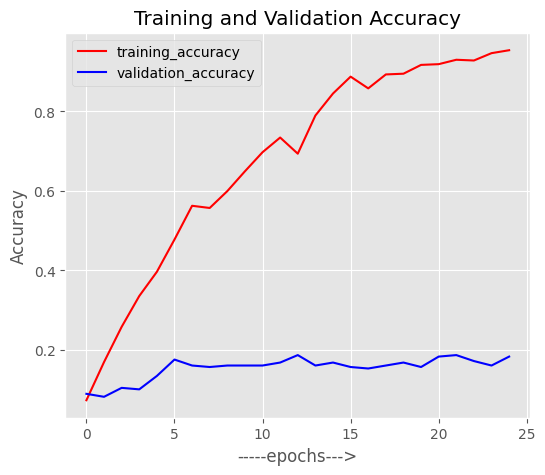

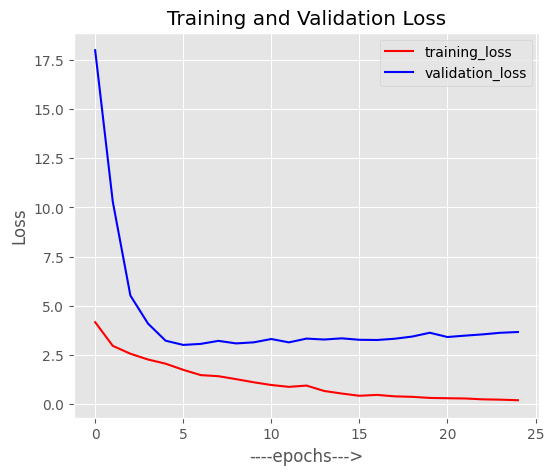

In [19]:
plt.style.use('ggplot')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(6, 5))

plt.plot(epochs, acc, 'r', label='training_accuracy')
plt.plot(epochs, val_acc, 'b', label='validation_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('-----epochs--->')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(6, 5))

plt.plot(epochs, loss, 'r', label='training_loss')
plt.plot(epochs, val_loss, 'b', label='validation_loss')
plt.title('Training and Validation Loss')
plt.xlabel('----epochs--->')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
predict = model.predict(test)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step


In [21]:
from sklearn.metrics import classification_report
predict_frame = pd.DataFrame([])
predict_frame['category'] = np.argmax(predict, axis=-1)
labels = dict((v,k) for k,v in val.class_indices.items())
predict_frame['category'] = predict_frame['category'].replace(labels)
print(classification_report(y_test, predict_frame['category'], zero_division=0))

              precision    recall  f1-score   support

         Bug       0.10      0.25      0.14        61
        Dark       0.00      0.00      0.00        28
      Dragon       0.09      0.04      0.06        24
    Electric       0.00      0.00      0.00        35
       Fairy       0.00      0.00      0.00        17
    Fighting       0.00      0.00      0.00        25
        Fire       0.00      0.00      0.00        47
      Flying       0.00      0.00      0.00         2
       Ghost       0.00      0.00      0.00        22
       Grass       0.25      0.02      0.03        64
      Ground       0.05      0.24      0.08        29
         Ice       0.04      0.13      0.07        23
      Normal       0.11      0.15      0.12        91
      Poison       0.00      0.00      0.00        28
     Psychic       0.00      0.00      0.00        46
        Rock       0.03      0.05      0.04        41
       Steel       0.00      0.00      0.00        22
       Water       0.09    

**Result Analysis 1**
* The validation accuracy is low.
* From the accuracy and loss plots, overfitting can be observed. A possible reason is that some primary type categories have very few Pokémon, resulting in insufficient samples.
* The prediction accuracy on the test set shows low classification accuracy for all types, indicating that the model does not perform well in classifying Pokémon across all attributes.
* Attempt to reduce the number of classification categories based on the current dataset.


**Reduce the Number of Classes: Attempt Classification for "Water", "Fire", and "Electric" Types Only**

In [22]:
select = ['Water', 'Electric', 'Fire']
pokemon_test1 = pokemon_test[pokemon_test['Primary_Type'].isin(select)]
pokemon_data1 = pokemon_data[pokemon_data['Primary_Type'].isin(select)]
print(pokemon_data1['Primary_Type'].value_counts())
print(pokemon_test1['Primary_Type'].value_counts())

Primary_Type
Water       114
Fire         53
Electric     40
Name: count, dtype: int64
Primary_Type
Water       103
Fire         47
Electric     35
Name: count, dtype: int64


**Create New Folders for new attempt at Training Set, Test Set, and Validation Set**

In [23]:
if os.path.exists('strain/'):
    shutil.rmtree('strain/')
if os.path.exists('stest/'):
    shutil.rmtree('stest/')
if os.path.exists('sval/'):
    shutil.rmtree('sval/') 
    
from shutil import copyfile, copy2
if not os.path.exists('strain/'):
    os.mkdir('strain/')
if not os.path.exists('stest/'):
    os.mkdir('stest/')
if not os.path.exists('sval/'):
    os.mkdir('sval/')
    
for class_ in pokemon_data1['Primary_Type'].unique():
    if not os.path.exists('strain/'+str(class_)+'/'):
        os.mkdir('strain/'+str(class_)+'/')
    if not os.path.exists('stest/'+str(class_)+'/'):
        os.mkdir('stest/'+str(class_)+'/')
    if not os.path.exists('sval/'+str(class_)+'/'):
        os.mkdir('sval/'+str(class_)+'/')

In [24]:
#dataset seplit
X_strain, X_sval, y_strain, y_sval = train_test_split(
    pokemon_data1, pokemon_data1['Primary_Type'],test_size=0.33, stratify=pokemon_data1['Primary_Type'],random_state=0)

X_stest, y_stest = pokemon_test1, pokemon_test1['Primary_Type']
X_strain

,Image,Pokemon,Primary_Type,Secondary_Type
620,magikarp.png,Magikarp,Water,NaN
111,magcargo.png,Magcargo,Fire,Rock
180,feraligatr.png,Feraligatr,Water,NaN
24,cloyster.png,Cloyster,Water,Ice
602,rapidash.png,Rapidash,Fire,NaN
...,...,...,...,...
154,wartortle.png,Wartortle,Water,NaN
330,blastoise.png,Blastoise,Water,NaN
715,zeraora.png,Zeraora,Electric,NaN
722,flareon.png,Flareon,Fire,NaN


In [25]:
for image,type_  in zip(images_data +'/' + X_strain['Image'], y_strain):
    copy2(image, 'strain/'+type_)

for image,type_ in zip(IMG_DIR +'/' + X_stest['Image'], y_stest):
    copy2(image, 'stest/'+type_)
    
for image,type_ in zip(images_data +'/' + X_sval['Image'], y_sval):
    copy2(image, 'sval/'+type_)
y_stest

3          Fire
4          Fire
5          Fire
6         Water
7         Water
         ...   
679       Water
680    Electric
681    Electric
688    Electric
707        Fire
Name: Primary_Type, Length: 185, dtype: object

In [26]:
datagen1 = ImageDataGenerator()

strain = datagen1.flow_from_directory('strain/')
stest = datagen1.flow_from_directory('stest/')
sval = datagen1.flow_from_directory('sval/')


Found 138 images belonging to 3 classes.
Found 185 images belonging to 3 classes.
Found 69 images belonging to 3 classes.


In [27]:
# Modeling
def build1():
    model1 = Sequential()  # Sequential model
    IMAGE_WIDTH = 256
    IMAGE_HEIGHT = 256
    IMAGE_CHANNELS = 3  # RGB three channels
    # Add an input layer
    model1.add(Lambda(lambda x: x, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
    
    model1.add(Conv2D(32, (3, 3), activation='relu'))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D(pool_size=(3, 3))) 
    model1.add(Dropout(0.3))
    
    model1.add(Conv2D(64, (3, 3), activation='relu'))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D(pool_size=(3, 3)))
    model1.add(Dropout(0.3))
    
    model1.add(Conv2D(128, (3, 3), activation='relu'))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D(pool_size=(3, 3)))
    model1.add(Dropout(0.3))
    
    model1.add(Flatten())
    model1.add(Dense(512, activation='relu'))
    model1.add(BatchNormalization())
    model1.add(Dropout(0.5))
    model1.add(Dense(3, activation='softmax'))  # Output layer with 3 neurons (for 3 primary types)
    
    # Show model summary
    model1.summary()
    
    model1.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    
    return model1

model1 = build1()
# Start training
history1 = model1.fit(strain, epochs=25, validation_data=sval)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)                    │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 82, 82, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 82, 82, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,292,547 (16.37 MB)

 Trainable params: 4,291,075 (16.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.3530 - loss: 2.4617 - val_accuracy: 0.2609 - val_loss: 58.0848
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5253 - loss: 1.6824 - val_accuracy: 0.2609 - val_loss: 47.0200
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6029 - loss: 0.9564 - val_accuracy: 0.2609 - val_loss: 33.1255
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7112 - loss: 0.7591 - val_accuracy: 0.2899 - val_loss: 20.7791
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7452 - loss: 0.5707 - val_accuracy: 0.3768 - val_loss: 11.5618
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8161 - loss: 0.5185 - val_accuracy: 0.3623 - val_loss: 7.1163
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7863 - loss: 0.4698 - val_accuracy: 0.3623 - val_loss: 5.8700
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8531 - loss: 0.3826 - val_accuracy: 0.3768 - val_loss: 6.2

**View Accuracy and Loss**

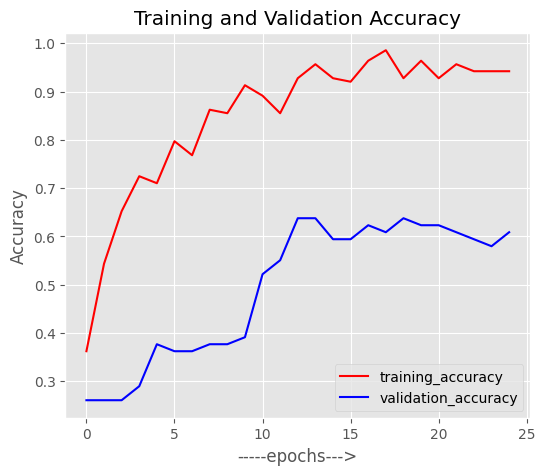

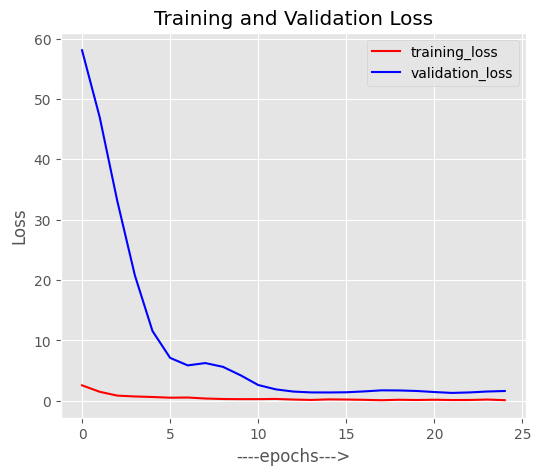

In [28]:
plt.style.use('ggplot')

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(6, 5))

plt.plot(epochs, acc, 'r', label='training_accuracy')
plt.plot(epochs, val_acc, 'b', label='validation_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('-----epochs--->')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(6, 5))

plt.plot(epochs, loss, 'r', label='training_loss')
plt.plot(epochs, val_loss, 'b', label='validation_loss')
plt.title('Training and Validation Loss')
plt.xlabel('----epochs--->')
plt.ylabel('Loss')
plt.legend()

plt.show()

From the results, we can see that after reducing to 3 classes, the classification accuracy improved significantly — rising from around 0.2 to approximately 0.6–0.7

In [29]:
# Make Predictions on the Test Set
predict1 = model1.predict(stest)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step


In [30]:
# Check Accuracy for Each Class
from sklearn.metrics import classification_report
predict_frame1 = pd.DataFrame([])
predict_frame1['category'] = np.argmax(predict1, axis=-1)
labels = dict((v,k) for k,v in sval.class_indices.items())
predict_frame1['category'] = predict_frame1['category'].replace(labels)
print(classification_report(y_stest, predict_frame1['category']))

              precision    recall  f1-score   support

    Electric       0.20      0.14      0.17        35
        Fire       0.30      0.19      0.23        47
       Water       0.53      0.67      0.59       103

    accuracy                           0.45       185
   macro avg       0.34      0.33      0.33       185
weighted avg       0.41      0.45      0.42       185



It can be seen that this classification model achieves high precision and recall for Water-type Pokémon.

**Misclassified Pokémon:**

In [31]:
def show_wrong_classification(y_stest, predict1, pokemon_test1):
    tmp = pokemon_test1[pokemon_test1.index.isin(y_stest.index)]
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))
    i=0
    for imag, true, pred in zip(IMG_DIR +'/' + tmp['Image'], tmp['Primary_Type'], predict1):
        if true!=pred:
            if i < 4:
                img = Image.open(imag)
                fig = plt.figure()
                ax[i].imshow(img)
                ax[i].set_title('Actual:'+str(true)+'\n'+'predict:'+ str(pred))
                i+=1

**Result Analysis 2**

From the results, it can be seen that the model misclassified some Pokémon attributes, indicating some issues in recognition.  
The classification performance varies across different attributes. However, if we ignore the animal features visually, we can observe that some Pokémon share similar colors.  

---

**View how pixel RGB channels are distributed among Fire, Water, and Electric-type Pokémon**


  0%|          | 0/3 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
/tmp/ipykernel_35/311891857.py:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your co

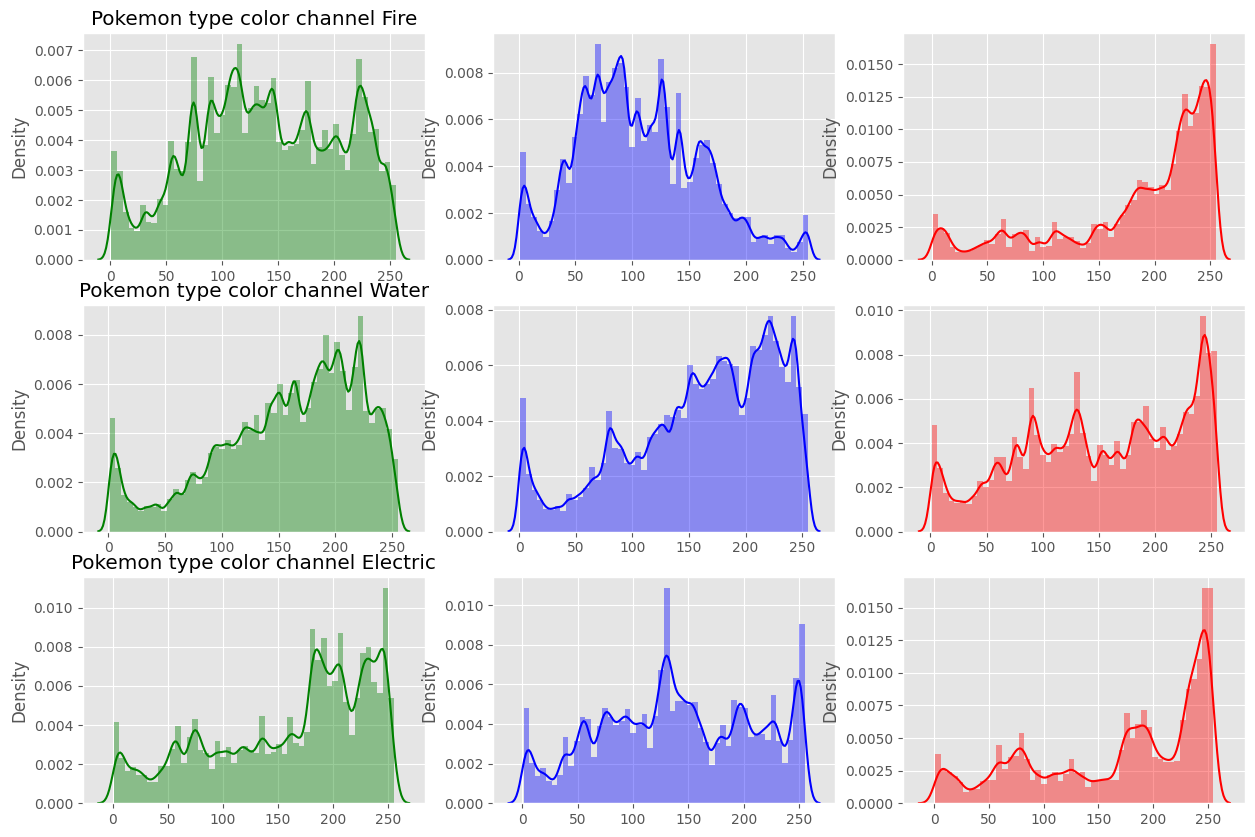

In [35]:

import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,3,figsize=(15,10))
k =0
import cv2
list_b =[]
list_r = []
list_g = []
from tqdm import tqdm
for type_ in tqdm(pokemon_test1['Primary_Type'].unique()):
    tmp = pokemon_test1[pokemon_test1['Primary_Type']==type_]
    for img in IMG_DIR +'/' + tmp['Image']:
        img = cv2.imread(img)
        b, g, r = cv2.split(img)
        color = 'blue'
        for i in b:
            for j in i:
                if j != 0:
                    list_b.append(j)
        color = 'green'
        for i in g:
            for j in i:
                if j != 0:
                    list_g.append(j)
        color = 'red'
        for i in r:
            for j in i:
                if j != 0:
                    list_r.append(j)
    sns.distplot(list_g, ax=axes[k, 0], color='g')
    sns.distplot(list_b, ax=axes[k, 1], color='b')
    sns.distplot(list_r, ax=axes[k, 2], color='r')
    axes[k, 0].set_title('Pokemon type color channel ' + type_)
    if type_ =='Fire':
        list_g_f = list_g
        list_b_f = list_b
        list_r_f = list_r
    elif type_=='Water':
        list_g_w = list_g
        list_b_w = list_b
        list_r_w = list_r
    else:
        list_g_e = list_g
        list_b_e = list_b
        list_r_e = list_r
    list_b =[]
    list_r = []
    list_g = []
    
    k += 1

**Result Analysis 3**

The pixel distributions of the green and red channels are similar among the three attributes.  
The blue channel shows the largest distribution differences:  
- Fire-type Pokémon have relatively low pixel intensity values between 200 and 255.  
- Water-type Pokémon show the opposite trend.  
- Electric-type Pokémon exhibit a more even pixel value distribution.  

Some Water, Electric, and Fire Pokémon have high red channel intensities, which can cause misclassification errors.

---

**Predict the attribute for a single image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


Text(0.5, 1.0, 'Actual: Electric\nPredict: Water')

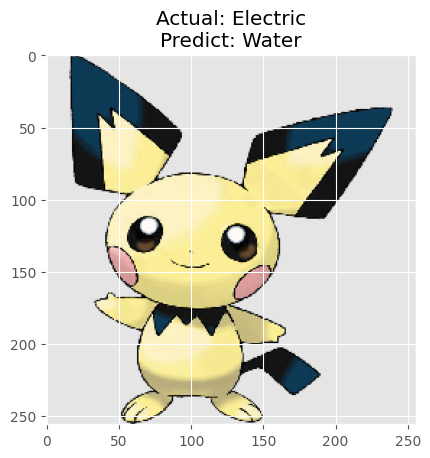

In [39]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.backend import expand_dims



num = 171

# Load image for display (original size)
img = Image.open(IMG_DIR + '/' + X_test['Image'][num])

# Load image for prediction (resize and normalize)
img1 = load_img(IMG_DIR + '/' + X_test['Image'][num], target_size=(256, 256))
data = img_to_array(img1) / 255.0  # Normalize
samples = expand_dims(data, 0)

# Predict with model1 (3-class CNN)
predict1 = model1.predict(samples)

# Convert prediction to readable label
predict_frame1 = pd.DataFrame([])
predict_frame1['category'] = np.argmax(predict1, axis=-1)
labels = {v: k for k, v in sval.class_indices.items()}  # invert dict
predict_frame1['category'] = predict_frame1['category'].replace(labels)

pred = predict_frame1['category'][0]
true = X_test['Primary_Type'][num]

# Display image with predicted and actual labels
fig = plt.figure()
plt.imshow(img)
plt.title(f'Actual: {true}\nPredict: {pred}')

**Result Analysis 4**

From the recognition results of a single image, it can be seen that some Water and Electric type Pokémon with red features are misclassified. At the same time, some Pokémon with red features are correctly classified (correct recognition exists for all three types).
The model stability is low; each time the model is trained, the prediction results vary to some extent.
Color has a certain impact on the recognition results but is also indispensable.

**Try converting images to grayscale.**

In [44]:
from numpy import expand_dims
import numpy as np
from PIL import Image
import pandas as pd

TYPES = {
    0: "Water",
    1: "Electric",
    2: "Fire"
}
key_list = list(TYPES.keys())
val_list = list(TYPES.values())

def replace_type(x):
    position = val_list.index(x)
    return key_list[position]

y_Strain = y_strain
y_Sval = y_sval
y_Stest = y_stest
y_Strain = y_Strain.apply(lambda x: replace_type(x))
y_Stest = y_Stest.apply(lambda x: replace_type(x))
y_Sval = y_Sval.apply(lambda x: replace_type(x))

In [46]:
from numpy import expand_dims
# Grayscale image using luminance method
def imgGray_Lum(im1):
    imgarray1 = np.array(im1, dtype=np.float32)  # Read image data as float type
    rows = im1.shape[0]
    cols = im1.shape[1]
    for i in range(rows):
        for j in range(cols):
            imgarray1[i, j, :] = (imgarray1[i, j, 0] * 0.299 + imgarray1[i, j, 1] * 0.587 + imgarray1[i, j, 2] * 0.114)
    return imgarray1.astype(np.uint8)  # Save as uint8 type image

bs = list()
bs1 = list()
bs2 = list()

# Grayscale training set
for imag, r in zip(X_strain['Image'], X_strain['Image'].index.values):
    I = Image.open(images_data + '/' + X_strain['Image'][r])
    I = I.resize((256, 256), Image.LANCZOS)  # Resize image using LANCZOS filter
    I = I.convert('RGB')
    I = np.array(I)
    I = imgGray_Lum(I)
    # Stack n three-dimensional arrays into one four-dimensional array, resulting in shape (n,256,256,3)
    bs.append(I[np.newaxis, :])
data = np.concatenate(bs, axis=0)
# Convert training set to array representation
X_Strain = np.empty((data.shape[0], 256, 256, 3))
for i in range(data.shape[0]):
    X_Strain[i] = np.array(data[i])
y_Strain = np.array(y_Strain)

# Grayscale validation set
for imag, r in zip(X_sval['Image'], X_sval['Image'].index.values):
    Iv = Image.open(images_data + '/' + X_sval['Image'][r])
    Iv = Iv.resize((256, 256), Image.LANCZOS)  # Resize image using LANCZOS filter
    Iv = Iv.convert('RGB')
    Iv = np.array(Iv)
    Iv = imgGray_Lum(Iv)
    bs1.append(Iv[np.newaxis, :])
data1 = np.concatenate(bs1, axis=0)
# Convert validation set to array representation    
X_Sval = np.empty((data1.shape[0], 256, 256, 3))
for i in range(data1.shape[0]):
    X_Sval[i] = np.array(data1[i])   
y_Sval = np.array(y_Sval)

# Grayscale test set
for imag, r in zip(X_stest['Image'], X_stest['Image'].index.values):
    Ie = Image.open(IMG_DIR + '/' + X_stest['Image'][r])
    Ie = Ie.resize((256, 256), Image.LANCZOS)  # Resize image using LANCZOS filter
    Ie = Ie.convert('RGB')
    Ie = np.array(Ie)
    Ie = imgGray_Lum(Ie)
    bs2.append(Ie[np.newaxis, :])
data2 = np.concatenate(bs2, axis=0)
# Convert test set to array representation   
X_Stest = np.empty((data2.shape[0], 256, 256, 3))
for i in range(data2.shape[0]):
    X_Stest[i] = np.array(data2[i])   
y_Stest = np.array(y_Stest)

print(y_Stest)

[2 2 2 0 0 0 1 1 2 2 0 0 2 2 0 0 0 0 0 2 2 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 1 2 0 0 0 0 1 2 1 2 2 2 2 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 2 2 0 0 0 0
 0 1 2 1 2 0 2 2 2 2 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0
 0 0 0 0 2 2 2 0 0 0 1 1 1 1 0 0 0 0 0 1 1 2 1 0 2 0 0 2 2 2 0 0 0 2 2 0 0
 1 1 0 0 0 2 0 0 0 0 1 0 0 0 0 0 1 1 1 2 2 2 2 0 0 0 2 2 2 2 2 0 0 1 1 1 2]


**Build CNN model for grayscale images**

In [48]:
# Build model
def build2():
    model2 = Sequential()  # Sequential model
    IMAGE_WIDTH = 256
    IMAGE_HEIGHT = 256
    IMAGE_CHANNELS = 3  # three channels
    
    # Add input layer
    model2.add(Lambda(lambda x: x, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
    
    model2.add(Conv2D(32, (3, 3), activation='relu'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(3, 3)))
    model2.add(Dropout(0.3))
    
    model2.add(Conv2D(64, (3, 3), activation='relu'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(3, 3)))
    model2.add(Dropout(0.3))
    
    model2.add(Conv2D(128, (3, 3), activation='relu'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(3, 3)))
    model2.add(Dropout(0.3))
    
    model2.add(Flatten())
    model2.add(Dense(512, activation='relu'))
    model2.add(BatchNormalization())
    model2.add(Dropout(0.5))
    model2.add(Dense(3, activation='softmax'))  # output layer, 3 neurons corresponding to 3 categories
    
    # Show model summary
    model2.summary()
    
    # Compile model with sparse categorical crossentropy loss, which converts non-one-hot labels automatically
    model2.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer="adam",
        metrics=['accuracy']
    )   
    return model2


In [49]:
model2 = build2()
history2 =  model2.fit(X_Strain,y_Strain, epochs=25, validation_data=(X_Sval,y_Sval))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_3 (Lambda)                    │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 84, 84, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 82, 82, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 82, 82, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,292,547 (16.37 MB)

 Trainable params: 4,291,075 (16.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.3325 - loss: 2.4163 - val_accuracy: 0.2174 - val_loss: 53.3086
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4714 - loss: 1.4823 - val_accuracy: 0.2174 - val_loss: 40.1444
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5792 - loss: 1.1019 - val_accuracy: 0.2609 - val_loss: 27.8650
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5966 - loss: 1.0839 - val_accuracy: 0.2609 - val_loss: 16.3716
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6412 - loss: 0.7763 - val_accuracy: 0.2609 - val_loss: 13.6270
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7404 - loss: 0.5961 - val_accuracy: 0.2174 - val_loss: 13.8184
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6904 - loss: 0.7238 - val_accuracy: 0.1739 - val_loss: 11.6256
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7751 - loss: 0.5582 - val_accuracy: 0.2464 - val_loss: 7.5176
Epoch

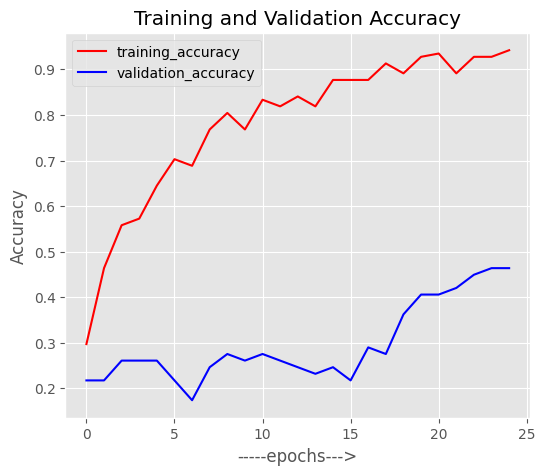

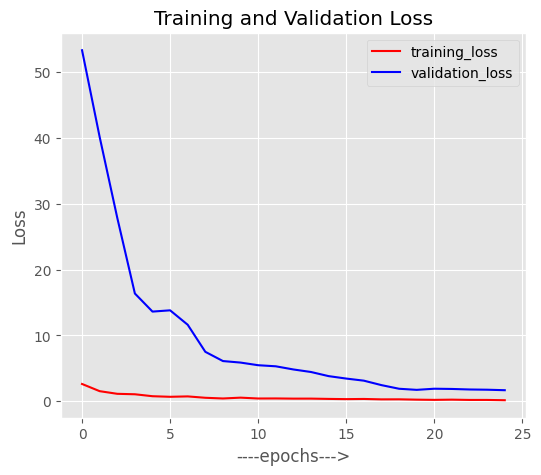

In [51]:
#View Accuracy and Loss
plt.style.use('ggplot')
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(6, 5))

plt.plot(epochs, acc, 'r', label='training_accuracy')
plt.plot(epochs, val_acc, 'b', label='validation_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('-----epochs--->')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(figsize=(6, 5))

plt.plot(epochs, loss, 'r', label='training_loss')
plt.plot(epochs, val_loss, 'b', label='validation_loss')
plt.title('Training and Validation Loss')
plt.xlabel('----epochs--->')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Predictiosn for the grayscale test set**

In [53]:
# Make predictions on the grayscale test set
predict3 = model2.predict(X_Stest)

# Get predicted class indices (integers)
y_pred = np.argmax(predict3, axis=-1)

# True labels as integers (assumed)
y_true = y_Stest

# Import classification_report
from sklearn.metrics import classification_report

# Print classification report with integer labels
print(classification_report(y_true, y_pred))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
              precision    recall  f1-score   support

           0       0.55      0.83      0.66       103
           1       0.12      0.09      0.10        35
           2       0.33      0.04      0.08        47

    accuracy                           0.49       185
   macro avg       0.34      0.32      0.28       185
weighted avg       0.41      0.49      0.41       185



**Result Analysis 5**

After training with grayscale images, the validation accuracy decreased compared to training without grayscale conversion.
The test set accuracy fluctuated slightly compared to the original.
Training on grayscale images yields average results, sometimes even worse.

**Try checking the recognition of a single grayscale image.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Text(0.5, 1.0, 'Actual: Electric\nPredict: Electric')

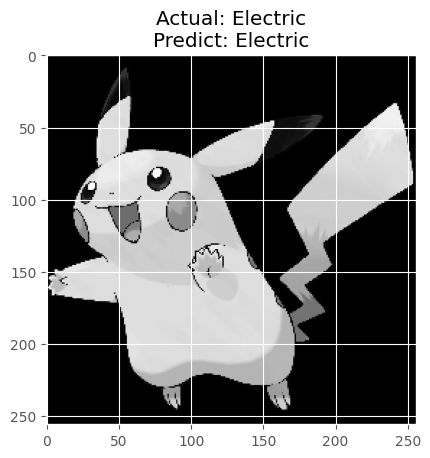

In [54]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

num = 6

im = X_Stest[num]  # Open output image
samples1 = expand_dims(im, 0)

# Use three-class grayscale model to predict
predict2 = model2.predict(samples1)
predict_frame2 = pd.DataFrame([])
predict_frame2['category'] = np.argmax(predict2, axis=-1)
labels1 = dict((v,k) for k,v in sval.class_indices.items())
# Prediction result and true result
predict_frame2['category'] = predict_frame2['category'].replace(labels1)
pred1 = predict_frame2['category'][0]
true1 = TYPES[y_Stest[num]]
# Display
fig = plt.figure()
plt.imshow(im.astype("uint8"))
plt.title('Actual: ' + str(true1) + '\n' + 'Predict: ' + str(pred1))


**Result Analysis 6**

After converting images to grayscale for prediction, it was found that many water-type Pokémon that were previously misclassified as fire-type due to their red color features were now correctly recognized. This means reducing RGB influence allows the model to focus more on animal characteristics, though some were still misclassified as electric-type.

Some Pokémon that were previously correctly recognized are now misclassified and vice versa, while some remain consistently correct or incorrect.

These results show that reducing RGB influence significantly helps in recognizing Pokémon with obvious red features, improving classification of water and electric types, but worsens recognition of fire types. For some water and electric types, reducing RGB impact has little effect, as their other features remain similar.

The model’s stability is low; re-running the prediction yields different results.

Both color and animal features influence Pokémon attribute classification, making recognition a challenging task.

# Summary

The CNN model built in this practice has relatively low stability and moderate performance in recognizing Pokémon attributes, especially for those with multiple attributes. This may be due to the limited number of data samples and the inherent difficulty of the images.

Both color features and animal characteristics are crucial for recognizing Pokémon attributes. From the training results on grayscale images, it is evident that color features hold a significant weight.

Image augmentation techniques (such as rotation, zooming, and brightness adjustment) were attempted in this practice but showed little improvement; red color features tend to interfere with classification.

This practice reveals that for datasets where color features play an important role in classification, careful consideration must be given to data processing and model improvements. It may require larger datasets or deeper networks.

Due to time constraints, deeper investigation was not conducted, so some results and analyses might be incomplete.